Die notwendigen Bibliotheken werden importiert.

In [11]:
""" imports """
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

Der Zustands- und Aktionenraum wird definiert. Außerdem simulieren wir den Verkaufsprozess mit unterschiedlichen Politiken - erst mit zufälligen Preisen, dann mit der gelernten Politik, dann mit der optimalen Politik.

In [2]:
""" parameters """ 
# state space
periods = 10 # initial period: 0, final period: periods
capacity_initial = 5 # max. capacity: capacity_initial, min. capacity: 0

state_initial = [0, capacity_initial]

# action space
price_max = 200 # maximum price
PRICES = 10 # discrete price points
prices_list = [price_max/PRICES*i for i in range(PRICES)]
prices_dict = {prices_list[i]: i for i in range(PRICES)}

# episodes with different policies
episodes_random = 500 # first: episodes with random policy
episodes_agent = 10*1000 # second: episodes with epsilon-greedy policy
episodes = episodes_random + episodes_agent
episodes_optimal = 1000 # third: episodes with near-optimal policy (price point next to optimal price)

episode_start_training = 0 # episode when training begins

Das Herzstück ist die Klasse DQN-Agent. Hier wird das Setup der beiden ("online" und "target") neuronalen Netze definiert. Außerdem werden die Metaparameter des Lernprozesses bzw. deren Änderungsvorschrift im Laufe des Prozesses festgelegt.

In [3]:
""" DQN agent """
# general setup from  https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter9-drl/dqn-cartpole-9.6.1.py
class DQNAgent:
    def __init__(self,
                 state_space, 
                 action_space, 
                 episodes,
                 episode_start_training):
        
        # episodes
        self.episodes = episodes
        self.episode_start_training = episode_start_training
        self.episodes_training = self.episodes - self.episode_start_training
        
        # action space
        self.action_space = action_space

        # experience buffer
        self.memory = []
        self.batch_size = 128
        self.recent_memories = 500*periods
        
        # counter
        self.episode_counter = 0
        self.episode_training_counter = 0
        self.update_count = 10

        # discount rate
        self.gamma_init = 0.9
        self.gamma_final = 0.9
        self.gamma = self.gamma_init
        
        # learning rate
        self.alpha_init = 0.1
        self.alpha_final = 0.01
        self.alpha = self.alpha_init

        # exploration vs. exploitation
        # epsilon-greedy with exponential epsilon decay
        self.epsilon_init = 0.1
        self.epsilon = self.epsilon_init
        self.epsilon_final = 0.1
        self.epsilon_decay = self.epsilon_final / self.epsilon
        if self.episodes_training >0:
            self.epsilon_decay = self.epsilon_decay ** \
                                 (1. / float(self.episodes_training))
        else:
            self.epsilon_decay = 0
        
        # online Q network
        n_inputs = state_space.shape[0]
        n_outputs = action_space.shape[0]
        self.q_model = self.build_model(n_inputs, n_outputs)
        self.q_model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
        
        # target Q Network
        self.target_q_model = self.build_model(n_inputs, n_outputs)
        self.update_weights() # initially both Q networks  identical weights


    def build_model(self, n_inputs, n_outputs):
        # neural network with two hidden layers and linear output layer
        inputs = Input(shape=(n_inputs, ), name='state')
        x = Dense(8, activation='relu', name='dense_1', kernel_initializer='random_normal', bias_initializer='zeros')(inputs)
        x = Dense(8, activation='relu', name='dense_2', kernel_initializer='random_normal', bias_initializer='zeros')(x)
        x = Dense(n_outputs, activation='linear', name='action')(x)
        q_model = Model(inputs, x)
        return q_model
    

    def update_weights(self):
        # copy trained online Q network params to target Q network
        self.target_q_model.set_weights(self.q_model.get_weights())


    def act(self, state):
        # epsilon-greedy policy
        if np.random.rand() < self.epsilon: # explore all actions
            action = np.random.randint(self.action_space.get_shape().as_list()[0])
        else: # exploit
            q_values = self.q_model.predict(state)
            action = np.argmax(q_values[0])  # select action with maximum Q value
        return action 


    def remember(self, item):
        # store experiences in replay buffer
        self.memory.append(item)


    def get_target_q_value(self, next_state, reward):
        # compute maximum Q value among next state's actions
        # Q_max = max_a' Q_target(s', a')
        q_value_target = np.amax(self.target_q_model.predict(next_state))

        # Q_max = reward + gamma * Q_max
        q_value_target *= self.gamma
        q_value_target += reward
        return q_value_target

    
    def train(self):
        # trains the online Q network
        # potentially updates target Q network
        
        # if training has started
        if self.episode_counter >= self.episode_start_training:
            
            # generates sars batch from experience memory samples
            sars_batch = random.sample(self.memory[-self.recent_memories:],min(len(self.memory),self.batch_size))
            
            # sars_batch = random.sample(self.memory, batch_size)
            state_batch = []
            q_values_batch = []
    
            # fixme: for speedup, this could be done on the tensor level
            # but easier to understand using a loop
            for state, action, reward, next_state, done in sars_batch:
                
                # policy prediction for a given state
                q_values = self.q_model.predict(state)
                
                # get Q_max
                q_value = self.get_target_q_value(next_state, reward)
    
                # correction of Q value for used action
                q_values[0][action] = reward if done else q_value
    
                # collect state and Q values in batch
                state_batch.append(state[0])
                q_values_batch.append(q_values[0])
    
            # train online Q network
            self.q_model.fit(np.array(state_batch),
                             np.array(q_values_batch),
                             batch_size=self.batch_size,
                             epochs=1,
                             verbose=0)
            
            # update meta parameters
            self.update_epsilon()
            self.update_alpha()
            self.update_gamma()
    
            # update target Q network weights every update_count episodes
            if self.episode_counter % self.update_count == 0:
                self.update_weights()
            
            # update training counter
            self.episode_training_counter += 1
    
        # update episode counter
        self.episode_counter += 1
        
        
    def update_epsilon(self):
        # decrease the exploration, increase exploitation
        if self.epsilon > self.epsilon_init:
            self.epsilon *= self.epsilon_decay
            
            
    def update_gamma(self):
        # decrease current reward, increase future reward
        self.gamma = self.gamma_init + (self.gamma_final-self.gamma_init)*self.episode_training_counter/self.episodes_training
    
            
    def update_alpha(self):
        # decrease observed q-value, increase learned q-value
        self.alpha = self.alpha_init + (self.alpha_final-self.alpha_init)*self.episode_training_counter/self.episodes_training
        
        K.set_value(self.q_model.optimizer.learning_rate, self.alpha)

Die folgenden Funktionen definieren das Kundenwahlverhalten und ermöglichen die Ermittlung der optimalen Preise mittels Dynamic Programming. Außerdem definieren wir eine Funktion, die den Zustandsvektor one-hot-encoded zurückgibt.

In [4]:
""" functions """
def customer_decision(price):
    # linear purchase probability function decision_prob(p)=a-1/price_max*p
    # takes price in [0, price_max], calculates purchase probability and returns decision (purchase=1)
    
    decision_prob = 1-1/price_max*price
    
    rand = np.random.uniform(0,1)
    
    if rand <= decision_prob:
        decision = 1
    else:
        decision = 0
    
    return decision


def calculate_state_values_and_optimal_prices():
    # determines optimal prices
    # only valid for above linear purchase probability function
    
    # initialize
    state_values = np.zeros((periods,capacity_initial+1))
    optimal_prices = np.zeros((periods,capacity_initial+1))
    
    # DP with two nested loops
    for period in reversed(range(periods-1)):
        for capacity in range(1,capacity_initial+1):
            
            optimal_price = 0.5*price_max+0.5*(state_values[period+1,capacity]-state_values[period+1,capacity-1])
            optimal_prices[period,capacity] = optimal_price
            
            purchase_prob = 1-1/price_max*optimal_price
            
            state_value = purchase_prob*(optimal_price + state_values[period+1,capacity-1]) \
                        + (1-purchase_prob)*state_values[period+1,capacity]
                        
            state_values[period,capacity] = state_value        

    return state_values, optimal_prices


def action_optimal_determination(state, optimal_prices):
    # determines next discrete price (action) for optimal price
    
    price_optimal = optimal_prices[state[0],state[1]]
    price_optimal = min(prices_list, key=lambda x:abs(x-price_optimal)) # discrete prices closest to optimal prices
    
    action_idx = prices_dict[price_optimal]
    
    return action_idx


def convert_state_to_state_OH(state):
    # state one-hot-encoding
    
    period = state[0]
    capacity = state[1]
    
    period_OH = np.eye(periods)[period]
    capacity_OH = np.eye(capacity_initial+1)[capacity]
    state_OH = np.concatenate((period_OH, capacity_OH))
    state_OH = np.reshape(state_OH, (1, periods+capacity_initial+1))
    
    return state_OH

Ein Simulationsdurchlauf wird in der folgenden Funktion definiert. Die Preise werden je nach gewählter Preispolitik bestimmt.

In [5]:
def episode(state_initial, periods, method):
    # simulates one episode
    
    # initialization
    period = state_initial[0]
    capacity = state_initial[1]
    reward_cum = 0
    sars_list = []
    
    # episode terminates when capacity = 0 or all periods simulated
    while capacity > 0 and period < periods-1: # simulated periods: [0, 1, ..., periods-2]
        
        # determine current state
        state = [period, capacity] # [ \in[0,periods-2] , \in[0,capacity_initial] ]
        state_OH = convert_state_to_state_OH(state)
                
        # action determined according to active policy
        if method == 'rand':
            action_idx = np.random.randint(PRICES)
        elif method == 'agent':
            action_idx = agent.act(state_OH)
        elif method == 'opt':
            action_idx = action_optimal_determination(state, optimal_prices)
        
        # determine purchase/no-purchase decision
        decision = customer_decision(prices_list[action_idx])
        
        # update state and cumulated reward
        if decision == 1:
            capacity -= 1
            reward = prices_list[action_idx]
            reward_cum += reward
        
        else:
            reward = 0
            
        # determine next state
        state_next = [period+1, capacity] # [ \in[1,periods-1] , \in[0,capacity_initial] ]
        state_next_OH = convert_state_to_state_OH(state_next)
        
        # update if episode terminated
        if period+1 == periods-1 or capacity == 0:
            done = True
        else:
            done = False
        
        # add experience to agent memory
        sars_tuple = (state_OH, action_idx, reward, state_next_OH, done)
        sars_list.append([state, prices_list[action_idx], reward, state_next])
        agent.remember(sars_tuple)
        
        # update period
        period += 1
            
    # train agent
    agent.train()
            
    return sars_list, reward_cum

Die Hauptfunktion initialisiert den DQN-Agenten...

In [6]:
""" main """   
# optimal state values and optimal prices
state_values, optimal_prices = calculate_state_values_and_optimal_prices()

# initialization of agent
init_state_tensor = tf.zeros((periods+capacity_initial+1,), dtype = tf.float16) # one-hot input for c and t
init_action_tensor = tf.zeros((PRICES,), dtype = tf.float16)

agent = DQNAgent(init_state_tensor, init_action_tensor, episodes, episode_start_training)
print('\n', agent.q_model.summary())
# print('\n', agent.target_q_model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
action (Dense)               (None, 10)                90        
Total params: 298
Trainable params: 298
Non-trainable params: 0
_________________________________________________________________

 None


... und speichert einige der initialen Werte - die Gewichte der neuronalen Netze und die damit initialen "besten" Preise.

In [ ]:
# track initial weights for online and target Q network
weights_q_model_initial = agent.q_model.get_weights()
weights_target_q_model_initial = agent.target_q_model.get_weights()

# track initial optimal prices for online and target Q network
best_prices_online_index_initial = np.zeros([periods,capacity_initial+1])
best_prices_online_initial = np.zeros([periods,capacity_initial+1])

best_prices_target_index_initial = np.zeros([periods,capacity_initial+1])
best_prices_target_initial = np.zeros([periods,capacity_initial+1])

# next prices to optimal prices
optimal_prices_rounded = np.zeros([periods,capacity_initial+1])

# loop through entire state space to obtain initial values described above
for t in range(periods-1):
    for c in range(1,capacity_initial+1):

        cur_state = [t,c]
        cur_state_OH = convert_state_to_state_OH(cur_state)

        cur_q_values_target = agent.target_q_model.predict(cur_state_OH)
        cur_q_values_online = agent.q_model.predict(cur_state_OH)

        best_prices_target_index_initial[t,c] = np.argmax(cur_q_values_target)
        best_prices_target_initial[t,c] = prices_list[int(best_prices_target_index_initial[t,c])]

        best_prices_online_index_initial[t,c] = np.argmax(cur_q_values_online)
        best_prices_online_initial[t,c] = prices_list[int(best_prices_online_index_initial[t,c])]

        optimal_prices_rounded[t,c] = prices_list[action_optimal_determination(cur_state, optimal_prices)]

Nun werden die verschiedenen Preispolitiken nacheinander simuliert und die erzielten Umsätze zur späteren Analye gespeichert.

In [7]:
# initialize episode
sars_episodes = []
reward_cum_episodes = []
reward_cum_episodes_optimal = []

reward_cum_incr_avg = [0]
reward_cum_incr_avg_optimal = [0]

# random policy
print('start episodes with random policy')
n = 1
for e in range(episodes_random):
    sars_list, reward_cum = episode(state_initial, periods, 'rand')

    sars_episodes += sars_list
    reward_cum_episodes.append(reward_cum)

    reward_cum_incr_avg.append(reward_cum_incr_avg[n-1]+(reward_cum-reward_cum_incr_avg[n-1])/n)
    if e % 500 == 0:
        print('episode:', e, 'episode revenue:', reward_cum, 'avg. episode revenue:', round(reward_cum_incr_avg[n],1))
    n += 1

# epsilon-greedy policy
print('\nstart episodes with epsilon-greedy policy')
for e in range(episodes_agent):
    sars_list, reward_cum = episode(state_initial, periods, 'agent')

    sars_episodes += sars_list
    reward_cum_episodes.append(reward_cum)

    reward_cum_incr_avg.append(reward_cum_incr_avg[n-1]+(reward_cum-reward_cum_incr_avg[n-1])/n)        
    if e % 500 == 0:
        print('episode:', e, 'episode revenue:', reward_cum, 'avg. episode revenue:', round(reward_cum_incr_avg[n],1))
    n += 1

# optimal policy
print('\nstart episodes with optimal policy')
n_opt = 1
for e in range(episodes_optimal):
    sars_list, reward_cum = episode(state_initial, periods, 'opt')

    sars_episodes += sars_list
    reward_cum_episodes_optimal.append(reward_cum)

    reward_cum_incr_avg_optimal.append(reward_cum_incr_avg_optimal[n_opt-1]+(reward_cum-reward_cum_incr_avg_optimal[n_opt-1])/n_opt)        
    if e % 500 == 0:
        print('episode:', e, 'episode revenue:', reward_cum, 'avg. episode revenue:', round(reward_cum_incr_avg_optimal[n_opt],1))
    n_opt += 1

start episodes with random policy
episode: 0 episode revenue: 40.0 avg. episode revenue: 40.0

start episodes with epsilon-greedy policy
episode: 0 episode revenue: 520.0 avg. episode revenue: 267.3
episode: 500 episode revenue: 700.0 avg. episode revenue: 331.4
episode: 1000 episode revenue: 280.0 avg. episode revenue: 350.0
episode: 1500 episode revenue: 240.0 avg. episode revenue: 360.4
episode: 2000 episode revenue: 520.0 avg. episode revenue: 366.9
episode: 2500 episode revenue: 600.0 avg. episode revenue: 368.1
episode: 3000 episode revenue: 80.0 avg. episode revenue: 369.8
episode: 3500 episode revenue: 300.0 avg. episode revenue: 372.5
episode: 4000 episode revenue: 360.0 avg. episode revenue: 375.0
episode: 4500 episode revenue: 540.0 avg. episode revenue: 377.0
episode: 5000 episode revenue: 300.0 avg. episode revenue: 378.3
episode: 5500 episode revenue: 520.0 avg. episode revenue: 379.1
episode: 6000 episode revenue: 420.0 avg. episode revenue: 380.7
episode: 6500 episode r

Die gelernte Preispolitik wird evaluiert, d.h. für jeden möglichen Zustand wird der beste Preis, laut "online" und "target" Netzwerk, ermittelt.

In [8]:
# evaluate learned policy
best_prices_target_index = np.zeros([periods,capacity_initial+1])
best_prices_target = np.zeros([periods,capacity_initial+1])

best_prices_online_index = np.zeros([periods,capacity_initial+1])
best_prices_online = np.zeros([periods,capacity_initial+1])

cur_states = []
cur_states_OH = []

# loop through entire state space to obtain initial values described above
for t in range(periods-1):
    for c in range(1,capacity_initial+1):

        cur_state = [t,c]
        cur_state_OH = convert_state_to_state_OH(cur_state)

        cur_states.append(cur_state)
        cur_states_OH.append(cur_state_OH)

        cur_q_values_target = agent.target_q_model.predict(cur_state_OH)
        cur_q_values_online = agent.q_model.predict(cur_state_OH)

        best_prices_target_index[t,c] = np.argmax(cur_q_values_target)
        best_prices_target[t,c] = prices_list[int(best_prices_target_index[t,c])]

        best_prices_online_index[t,c] = np.argmax(cur_q_values_online)
        best_prices_online[t,c] = prices_list[int(best_prices_online_index[t,c])]

# track final weights for online and target Q network
weights_q_model_final = agent.q_model.get_weights()
weights_target_q_model_final = agent.target_q_model.get_weights()

Zuletzt visualisieren wir die Ergebnisse, d.h. den durchschnittlich erzielten Umsatz im Verlauf des gesamten Lerprozesses, der durchschnittliche Umsatz der letzten 1000 Episoden und den bei "optimaler" Politik ("optimal", da nicht die tatsächlich optimalen Preise, sondern die nächstgelegenen Preispunkte verwendet wurden). Der Übergang von einer zufälligen zu der gelernten Preispolitik ist klar zu identifizieren. Ab Beginn des Lernprozesses wächst der durchschnittliche Umsatz wächst monoton mit abnehmender Steigung. Eine Sättigung ist auch nach 10.000 Episoden nicht erreicht, sodass eine weitere Verbesserung der gelernten Politik mit mehr Episoden erwartet werden kann.

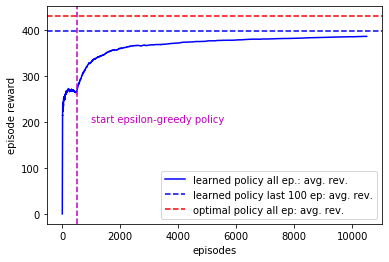

In [16]:
""" visualization """
# revenues
plt.plot(reward_cum_incr_avg,color='b',label='learned policy all ep.: avg. rev.')
plt.axhline(np.mean(reward_cum_episodes[-1000:]),color='b',linestyle='--',label='learned policy last 100 ep: avg. rev.')

plt.axhline(reward_cum_incr_avg_optimal[-1],color='r',linestyle='--',label='optimal policy all ep: avg. rev.')

plt.axvline(episodes_random,color='m',linestyle='--')

plt.text(episodes_random+500,200,'start epsilon-greedy policy',color='m')

plt.xlabel('episodes')
plt.ylabel('episode reward')

plt.legend()

Der Vergleich der "optimalen" und gelernten Preise zeigt eine hohe Übereinstimmung bei den Zuständen, in denen mehr Restkapazität als Restzeit verbleibt (untere, rechte Dreiecksmatrix). In der linken, oberen Dreiecksmatrix ist die Tendenz zu hohen Preis auch bei den gelernten Preisen erkennbar, allerdings gibt es noch zahlreiche Elemente, bei denen die Preise nicht mit den "optimalen" Preisen übereinstimmen. Ein Teil der Erklärung ist, dass diese Zustände weniger häufig bzw. überhaupt nicht besucht werden und damit keine Beobachtungen für eine Verbesserung der Preispolitik in diesen Zuständen gelernt werden kann. In der Ursprungsperiode (t=0) beispielsweise, ist die Kapazität immer c=5, sodass die Zustände mit t=0 und c=0,...,4 nie besucht werden. Ausgehend von t=0 und c=5 können nur die Zustände auf der Diagonalen (Verkauf in jeder Periode), sowie die Zustände "unterhalb" dieser Diagonalen besucht werden.

Text(33.0, 0.5, 'period')

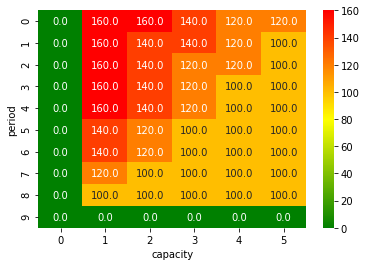

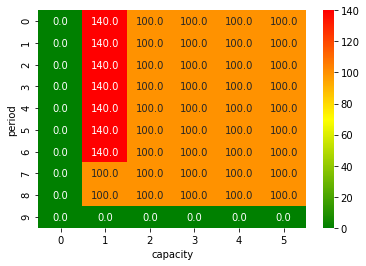

In [17]:
# optimal prices
figure = plt.figure()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

yticklabels = np.linspace(0,PRICES-1,PRICES, dtype=int)

sns.heatmap(optimal_prices_rounded[:,:], annot=True, yticklabels=yticklabels, cmap=cmap, fmt='.1f')
plt.xlabel('capacity')
plt.ylabel('period')

# learned prices
figure = plt.figure()

sns.heatmap(best_prices_online[:,:], annot=True, yticklabels=yticklabels, cmap=cmap, fmt='.1f')
plt.xlabel('capacity')
plt.ylabel('period')